In [1]:
import os
import sys
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import boxcox
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
def plot_3d_rfm_clusters(df):
    """
    Generates an interactive 3D scatter plot for RFM clustering.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'Recency', 'Frequency', 'MonetaryValue', and 'Cluster' columns.

    Returns:
        None (Displays the plot)
    """
    # Create interactive 3D scatter plot
    fig = px.scatter_3d(df, 
                         x='Recency', 
                         y='Frequency', 
                         z='MonetaryValue', 
                         color='Cluster',  # Assign different colors to clusters
                         title="3D Cluster Visualization of RFM Segments",
                         opacity=0.8)

    # Show the interactive plot
    fig.show()

In [3]:
def plot_2d_rfm_clusters(df):
    """
    Generates three 2D scatter plots for RFM clustering: 
    1. Recency vs Frequency
    2. Recency vs Monetary Value
    3. Frequency vs Monetary Value

    Parameters:
        df (pd.DataFrame): DataFrame containing 'Recency', 'Frequency', 'MonetaryValue', and 'Cluster' columns.

    Returns:
        None (Displays the plots)
    """
    # Define unique clusters and color palette
    clusters = df['Cluster'].unique()
    colors = sns.color_palette("tab10", len(clusters))
    color_map = {cluster: colors[i] for i, cluster in enumerate(clusters)}

    # Create a figure with 3 subplots (1 row, 3 columns)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot Recency vs Frequency
    for cluster in clusters:
        subset = df[df['Cluster'] == cluster]
        axes[0].scatter(subset['Recency'], subset['Frequency'], 
                        label=f'Cluster {cluster}', color=color_map[cluster], alpha=0.8)
    axes[0].set_xlabel("Recency")
    axes[0].set_ylabel("Frequency")
    axes[0].set_title("Recency vs Frequency")

    # Plot Recency vs Monetary Value
    for cluster in clusters:
        subset = df[df['Cluster'] == cluster]
        axes[1].scatter(subset['Recency'], subset['MonetaryValue'], 
                        label=f'Cluster {cluster}', color=color_map[cluster], alpha=0.8)
    axes[1].set_xlabel("Recency")
    axes[1].set_ylabel("Monetary Value")
    axes[1].set_title("Recency vs Monetary Value")

    # Plot Frequency vs Monetary Value
    for cluster in clusters:
        subset = df[df['Cluster'] == cluster]
        axes[2].scatter(subset['Frequency'], subset['MonetaryValue'], 
                        label=f'Cluster {cluster}', color=color_map[cluster], alpha=0.8)
    axes[2].set_xlabel("Frequency")
    axes[2].set_ylabel("Monetary Value")
    axes[2].set_title("Frequency vs Monetary Value")

    # Add legend (only once)
    axes[0].legend()

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

# Dataset

A df with 'Recency', 'Frequency', 'MonetaryValue' column for every user. <br>

Recency: Days passed since last transaction <br>
Frequency: Number of transactions <br>
MonetaryValue: Volume

In [4]:
df = pd.read_csv('customer_rfm_data.csv', index_col=None)
df

CustomerID  Recency  Frequency  MonetaryValue
0              1        4         23          65466
1              2       30         20          10198
2              3       13          9          21281
3              4        9         46          54425
4              5        1         32          32897
...          ...      ...        ...            ...
9995        9996       58        104         152115
9996        9997       68          2          68881
9997        9998       87         18            982
9998        9999       15         29          25625
9999       10000        7          9          14879

[10000 rows x 4 columns]

In [5]:
df.describe()

CustomerID       Recency    Frequency  MonetaryValue
count  10000.00000  10000.000000  10000.00000   10000.000000
mean    5000.50000     20.149300     50.44890   49812.336100
std     2886.89568     22.022187     51.01797   49765.482352
min        1.00000      0.000000      1.00000       2.000000
25%     2500.75000      4.000000     14.00000   14634.000000
50%     5000.50000     12.000000     35.00000   34864.000000
75%     7500.25000     27.000000     70.00000   68260.000000
max    10000.00000     90.000000    474.00000  461007.000000

# Preprocessing

Transformation and normalization steps will be applied. Since the distribution of the Recency, Frequency, and MonetaryValue metrics is not normal, a transformation (e.g. log transformation) is needed

In [6]:
# Data needs to be positive to perform transformation
df['Recency'] = df['Recency'] + 1

In [7]:
# Select features
features = ['Recency', 'Frequency', 'MonetaryValue']

# Apply Box-Cox transformation
df_boxcox_transformed = pd.DataFrame(index=df.index)
lambdas = {}  # Store lambda values for reference

for col in features:
    df_boxcox_transformed[col], lambdas[col] = boxcox(df[col])  # No need to shift since you've added 1

# Standardization (Normalization)
scaler = StandardScaler()
df_norm = scaler.fit_transform(df_boxcox_transformed)

# Convert back to DataFrame
df_norm = pd.DataFrame(df_norm, columns=features, index=df.index)

# Print lambda values
print("Box-Cox Lambda Values:", lambdas)

# Show first few rows
df_norm.head()

Box-Cox Lambda Values: {'Recency': 0.13087433615190686, 'Frequency': 0.24725167117158145, 'MonetaryValue': 0.2637964133064613}


Recency  Frequency  MonetaryValue
0 -0.788524  -0.321406       0.643053
1  0.805114  -0.431604      -0.933731
2  0.063824  -0.993136      -0.400352
3 -0.227445   0.285109       0.449623
4 -1.456259  -0.045378      -0.032153

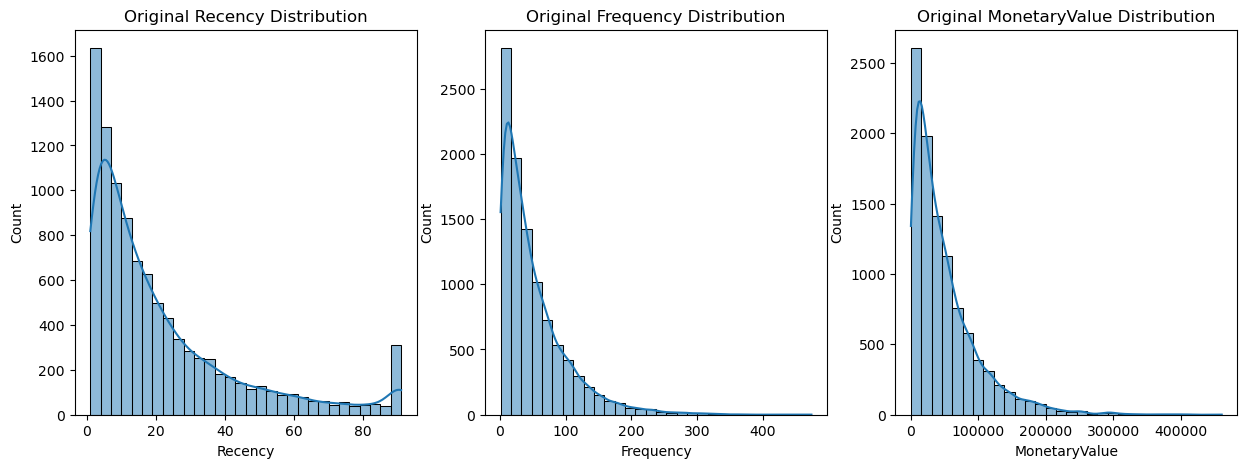

In [8]:
# Before boxcox transformation
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
columns = ['Recency', 'Frequency', 'MonetaryValue']

for i, col in enumerate(columns):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Original {col} Distribution")

plt.show()

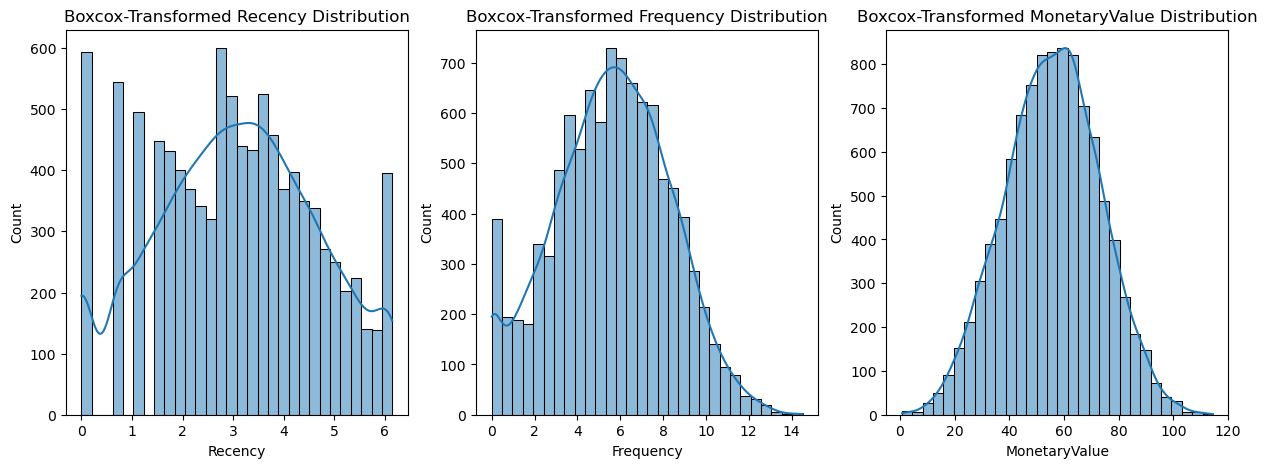

In [9]:
# After boxcox transformation
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(columns):
    sns.histplot(df_boxcox_transformed[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Boxcox-Transformed {col} Distribution")

plt.show()

# Clustering

/Users/simgesenyuz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/simgesenyuz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Num of clusters: 1
SSE for num of clusters: 30000.0
Num of clusters: 2
SSE for num of clusters: 23172.117224259702


/Users/simgesenyuz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Num of clusters: 3
SSE for num of clusters: 18640.264912249826


/Users/simgesenyuz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Num of clusters: 4
SSE for num of clusters: 15301.99989225524


/Users/simgesenyuz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Num of clusters: 5
SSE for num of clusters: 13443.141566305576


/Users/simgesenyuz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Num of clusters: 6
SSE for num of clusters: 11789.011533711058


/Users/simgesenyuz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Num of clusters: 7
SSE for num of clusters: 10844.902547146703


/Users/simgesenyuz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Num of clusters: 8
SSE for num of clusters: 9987.804826105197


/Users/simgesenyuz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Num of clusters: 9
SSE for num of clusters: 9282.432945804108


/Users/simgesenyuz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Num of clusters: 10
SSE for num of clusters: 8651.890366959027


/Users/simgesenyuz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Num of clusters: 11
SSE for num of clusters: 8109.533440026121


/Users/simgesenyuz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Num of clusters: 12
SSE for num of clusters: 7695.705672517882


/Users/simgesenyuz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Num of clusters: 13
SSE for num of clusters: 7270.4490126715355


/Users/simgesenyuz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Num of clusters: 14
SSE for num of clusters: 6969.671516034877


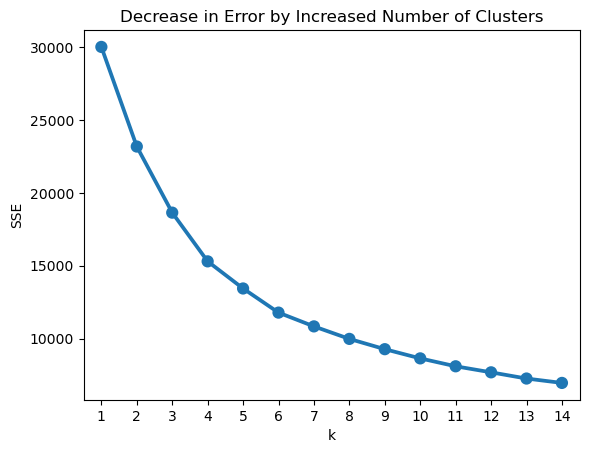

In [10]:
sse = {}
for k in range(1, 15):
  
    # Initialize KMeans with k clusters and fit it 
    kmeans = KMeans(n_clusters=k, random_state=1).fit(df_norm)
    
    # Assign sum of squared distances to k element of the sse dictionary
    sse[k] = kmeans.inertia_   
    print(f'Num of clusters: {k}')
    print(f'SSE for num of clusters: {kmeans.inertia_}')

# Add the plot title, x and y axis labels
plt.title('Decrease in Error by Increased Number of Clusters')
plt.xlabel('k')
plt.ylabel('SSE')

# Plot SSE values for each k stored as keys in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

# 4 Clusters

Recency: Days passed since last transaction (in the last 3 months) <br>
Frequency: Number of transactions (in the last 3 months) <br>
MonetaryValue: Volume (in the last 3 months)

In [11]:
kmeans = KMeans(n_clusters=4, random_state=1) 
kmeans.fit(df_norm)
cluster_labels = kmeans.labels_

/Users/simgesenyuz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [12]:
df_k4 = df.assign(Cluster=cluster_labels)

df_k4[['Recency', 'Frequency', 'MonetaryValue']] = df_k4[['Recency', 'Frequency', 'MonetaryValue']] - 1
grouped = df_k4.groupby(['Cluster'])

grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         19.86      8.06      67135.53  2398
1          2.92     59.79      51737.55  2657
2         34.44     82.83      71100.53  2485
3         24.60     44.91       9337.75  2460

In [13]:
plot_3d_rfm_clusters(df_k4)

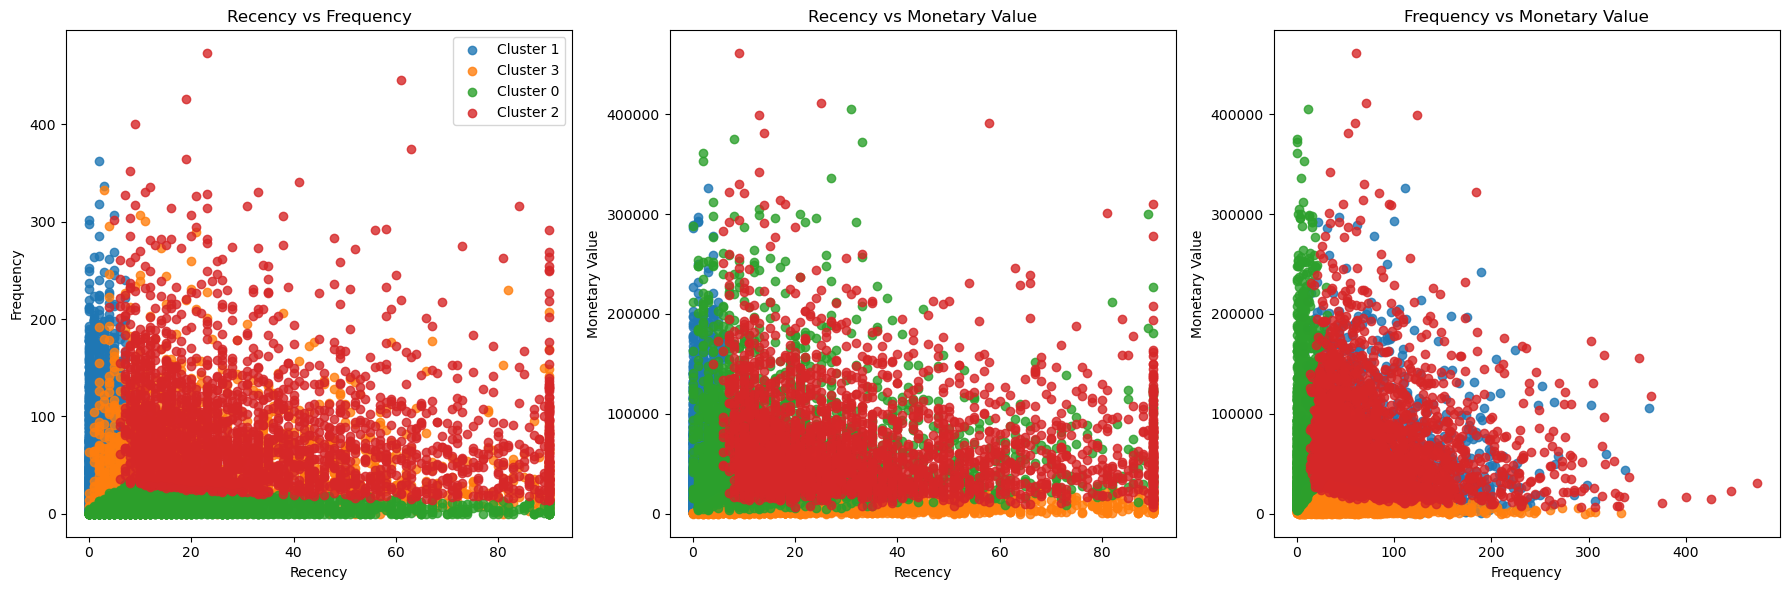

In [14]:
plot_2d_rfm_clusters(df_k4)

## Relative Importance of RFM Features

In [15]:
cluster_avg = df_k4[['Recency', 'Frequency', 'MonetaryValue', 'Cluster']].groupby(['Cluster']).mean() 
population_avg = df[['Recency', 'Frequency', 'MonetaryValue']].mean()
relative_imp = cluster_avg / population_avg
relative_imp

Recency  Frequency  MonetaryValue
Cluster                                    
0        0.939210   0.159824       1.347769
1        0.137845   1.185070       1.038649
2        1.628548   1.641895       1.427368
3        1.163313   0.890114       0.187459

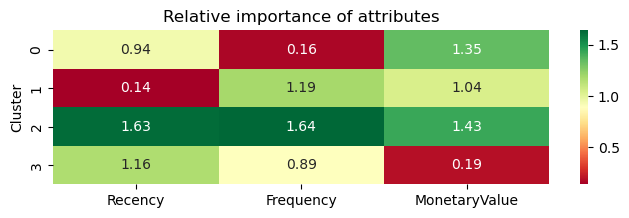

In [16]:
plt.figure(figsize=(8, 2))
plt.title('Relative importance of attributes')

sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

# 5 Clusters

Recency: Days passed since last transaction <br>
Frequency: Number of transactions <br>
MonetaryValue: Volume

In [17]:
kmeans = KMeans(n_clusters=5, random_state=1) 
kmeans.fit(df_norm)
cluster_labels = kmeans.labels_

/Users/simgesenyuz/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [18]:
df_k5 = df.assign(Cluster=cluster_labels)

df_k5[['Recency', 'Frequency', 'MonetaryValue']] = df_k5[['Recency', 'Frequency', 'MonetaryValue']] - 1
grouped = df_k5.groupby(['Cluster'])

grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         34.45     22.34      12326.40  1733
1          4.44     59.94      88776.52  1928
2         38.25     84.15      58004.91  2274
3         17.00      8.20      71477.62  2053
4          5.64     65.61      13391.58  2012

In [19]:
plot_3d_rfm_clusters(df_k5)

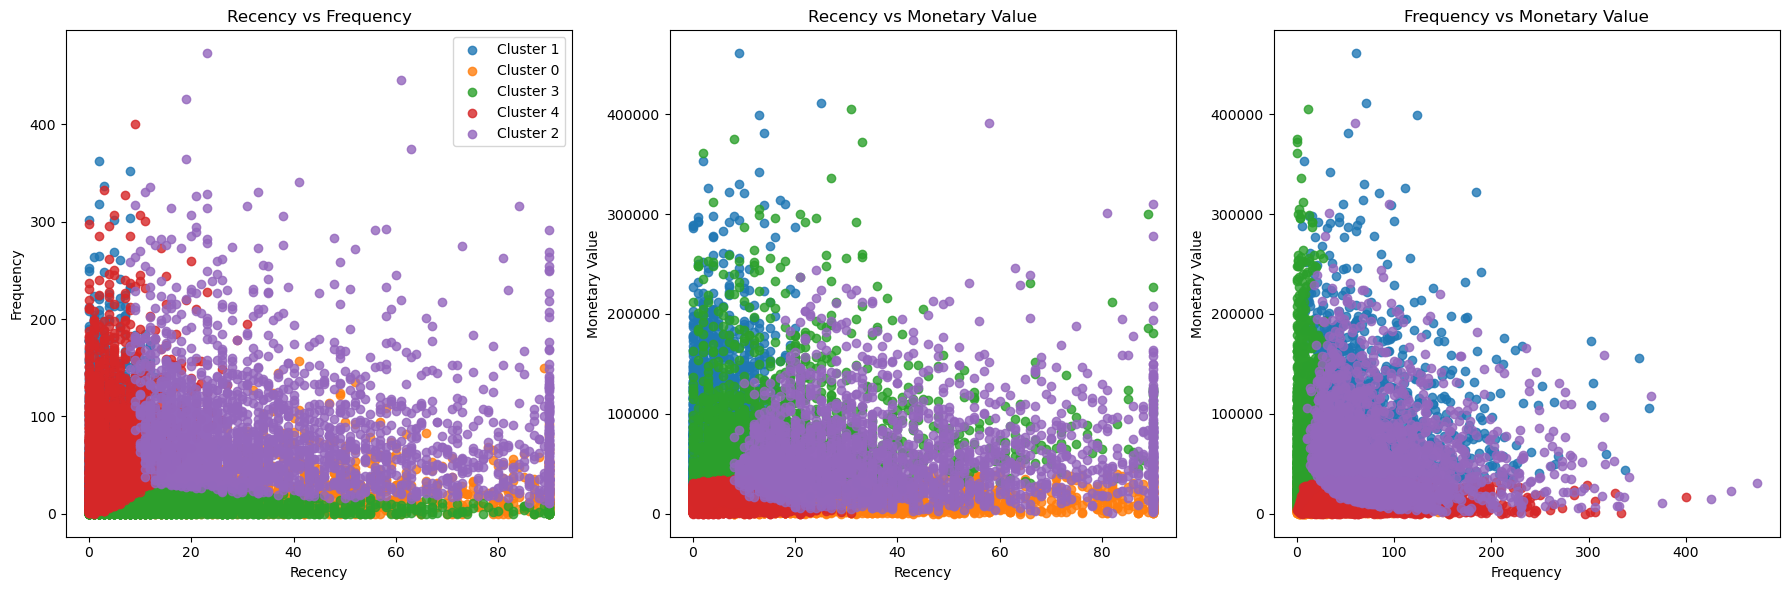

In [20]:
plot_2d_rfm_clusters(df_k5)

## Relative Importance of RFM Features

In [21]:
cluster_avg = df_k5[['Recency', 'Frequency', 'MonetaryValue', 'Cluster']].groupby(['Cluster']).mean() 
population_avg = df[['Recency', 'Frequency', 'MonetaryValue']].mean()
relative_imp = cluster_avg / population_avg
relative_imp

Recency  Frequency  MonetaryValue
Cluster                                    
0        1.629063   0.442913       0.247457
1        0.209855   1.188058       1.782220
2        1.808373   1.668102       1.164469
3        0.803878   0.162477       1.434938
4        0.266801   1.300600       0.268841

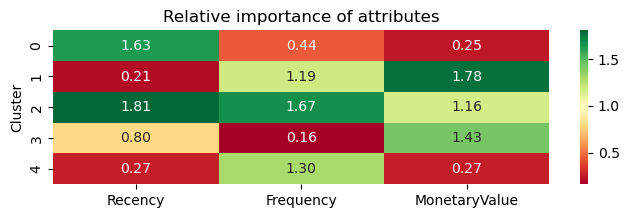

In [22]:
plt.figure(figsize=(8, 2))
plt.title('Relative importance of attributes')

sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()